**First we are Installing TensorLy and TensorLy-Torch python packages:**

In [1]:
pip install -U tensorly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 4.1 MB/s eta 0:00:00


In [2]:
pip install -U tensorly-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 2.8 MB/s eta 0:00:00


**Now importing all the modules needed for the implementation of TRL and TCL and the experiments done in the paper:**

**NOTE:** In order to work smoothly and interchageably with TensorLy and PyTorch I've moved TensorLy backend to PyTorch instead of NumPy.

In [3]:
import torch
import tltorch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.optim as optim
import tensorly as tl
from functools import partial
from typing import Any, Optional
from tqdm import tqdm

tl.set_backend('pytorch')

from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _ovewrite_named_param, handle_legacy_interface

import matplotlib.pyplot as plt
from tensorly.base import tensor_to_vec, partial_tensor_to_vec
from tensorly.datasets.synthetic import gen_image




#We start with implementing TRL and TCL:
In the paper the authors introduced the Tensor Resgressin Layer (TRL) as

$$\space$$
 $$Y = \space ⟨ \mathcal{X}, \mathcal{W} \rangle_{N + 1} +  \space b \space\space\space\space (1)$$
   $$\space$$

  Where $Y \in \mathbb{R}^{S \times O}$ is the output of the layer, $\mathcal{X} \in \mathbb{R}^{S \times I_0 \times I_1 \times \dots \times I_N }$ is the layer input and $\mathcal{W} \in \mathbb{R}^{I_0 \times I_1 \times … \times I_N \times O}$ are the layer's weights. $S$ reffers to the batch size and $O$ to the numbers of labels per sample. Also notice that $\mathcal{W}$ is subject to the decomposed Tucker form of

  $$\space$$
  $$ \mathcal{W}=[\mathcal{G};U^{(0)}, \dots, U^{(N)}, U^{(N+1)}] \space\space\space $$
  $$\space$$


Where $\mathcal{G} \in \mathbb{R}^{R_0, \times \dots \times R_{N} \times R_{N+1}}$, $U^{(k)} \in \mathbb{R}^{I_k \times R_k}$ for each $k$ in $[0, \dots ,N]$ and $U^{N+1} \in \mathbb{R}^{O \times R_{N + 1}}$.
 $$\space$$

 Next we use the usefull proposition the authors present in section 5 of the paper called "**Efficient implementation of tensor regression layeres**". We see that $(1)$ can be written as:

$$\space$$
$$Y = \space \langle \mathcal{X}, \mathcal{G}×_0 U^{(0)} \times_1 U^{(1)} \times_2 \dots \times_{N+1}U^{(N+1)} \rangle $$
$$\space$$
Which in turn can be written equivalently as:

$$\space$$
$$Y = \space \langle \mathcal{X} \times_0 (U^{(0)})^T \times_1 (U^{(1)})^T \times \dots \times_{N} (U^{(N)})^T  ,\mathcal{G} \times_{N+1}U^{(N+1)} \rangle_{N+1} + b \space\space\space (2)$$
$$\space$$


That way, most of our computations are made on a lower dimension space rather than on the original dimensions of $\mathcal{X}$, this is due to the fact that $R_k \leq I_K$ for all $k$ in $[0, \dots, N]$. Implementing the TRL following this logic we get that first we apply a TCL on $\mathcal{X}$ and only then apply the TRL on the output toghether with $\mathcal{G} \times_{N+1} U^{(N+1)}$ resulting with $(2)$.
I am implementing TRL such that it will have both options available $(1)$ and $(2)$. I am also making the addition of the bias $b$ as optional.$$\space$$
NOTE: For the TRL when efficient=False then the TRL takes same rank values for all modes.

In [4]:
class TCL(nn.Module):
    def __init__(self, input_dim, ranks):
        super(TCL, self).__init__()
        self.input_dim = input_dim
        self.ranks = ranks
        self.W = nn.Parameter(torch.randn(input_dim))
        core, factors = tl.decomposition.tucker(self.W, ranks)
        for i, factor in enumerate(factors):
            self.register_parameter(f"factor_{i}", nn.Parameter(factor))
    def forward(self, x):
      assert len(x.shape) == len(self.ranks) + 1, "The input Tensor x has to have a batch dimension"

      weights = [getattr(self, f"factor_{i}") for i in range(len(self.ranks))]

      return tl.tenalg.multi_mode_dot(x, weights, modes=[i+1 for i in range(len(self.ranks))], transpose=True) # Dont forget to change back to normilized_weights


class TRL(nn.Module):
    def __init__(self,input_dim, ranks, labels, bias=False, efficient=False):
        super(TRL, self).__init__()
        self.bias = bias
        self.efficient = efficient
        if efficient:
          self.input_dim = input_dim
          self.ranks = ranks
          self.TCL = TCL(input_dim, ranks[:-1])
          rank_list = [ranks[i] for i in range(len(ranks) -1)]
          rank_list.append(labels)
          W = torch.nn.Parameter(torch.randn(rank_list))
          g_core, factors = tl.decomposition.partial_tucker(W, rank = self.ranks[-1], modes = [tl.ndim(W) - 1])[0]
          self.core_weights = nn.Parameter(g_core)
          self.weights_factor = nn.Parameter(factors[0])
        else:
          dims = [i for i in input_dim]
          dims.append(labels)
          W = torch.nn.Parameter(torch.randn(dims))
          self.weights = tltorch.FactorizedTensor.from_tensor(W, rank=ranks[0], factorization='tucker')
        if bias:
          self.weights_bias = nn.Parameter(torch.randn(labels))
        if len(input_dim) < 3:  # for tensors with the shape (Batch, H, W)
          self.normalize_1 = torch.nn.BatchNorm1d(input_dim[0])
          self.normalize_2 = torch.nn.BatchNorm1d(ranks[0])
        if len(input_dim) == 3: # for tensors with the shape (Batch, C, H, W)
          self.normalize_1 = torch.nn.BatchNorm2d(input_dim[0])
          self.normalize_2 = torch.nn.BatchNorm2d(ranks[0])


    def forward(self, x):
      if self.efficient:
        g_core = self.core_weights
        factors = self.weights_factor
        w = tl.tenalg.mode_dot(g_core, factors, tl.ndim(g_core) - 1)
        x = self.normalize_1(x)
        x = self.TCL(x)
        x = self.normalize_2(x)
        if self.bias:
          b = self.weights_bias
          x = tl.tenalg.inner(x, w, n_modes= tl.ndim(x)-1) + b
        else:
            x = tl.tenalg.inner(x, w, n_modes= tl.ndim(x)-1)

        return x

      else:
        ## Here implement W as if it's given in its decomposed tucker form.
        ## Work with TensorLy to understand how to initialize weights and
        ## incorporate Tucker inorder to construct W from its core and factors
        if self.bias:
          b = self.weights_bias
          W = self.weights.to_tensor()
          x = tl.tenalg.inner(x, W, n_modes = tl.ndim(x) -1) + b
        else:
          x = self.normalize_1(x)
          W = self.weights.to_tensor()
          x = tl.tenalg.inner(x, W, n_modes = tl.ndim(x) -1)

        return x




My version of the generalized tensor inner product using torch.einsum.
this method is implemented in TensorLy as well.

In [6]:
def gener_inner_prod(x, y):
  x_dim = [x.shape[i] for i in range(len(x.shape))]
  y_dim = [y.shape[i] for i in range(len(y.shape))]
  x_test = x_dim[1:]
  y_test = y_dim[:-1]
  assert x_test == y_test, 'the tensors dimensions are not matching'
  return torch.einsum('i..., ...j -> ij', x, y)



# Creating the Data Set for the sythetic experiment in the paper:

/usr/local/lib/python3.10/dist-packages/tensorly/backend/pytorch_backend.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(


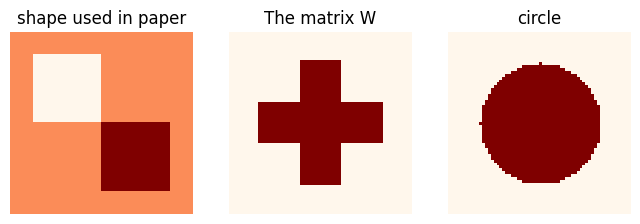

In [5]:
# Constructing the white/orange/red ractangle image from the paper
image_1 = 0.5*torch.ones(64, 64)
image_1[8:32, 8:32] = 0
image_1[32:56, 32:56] = 1
image_1 = tl.tensor(image_1)

# Constructing the swiss flag image
image_2 = gen_image(region='swiss', image_height=64, image_width=64)
image_2 = tl.tensor(image_2)

# Constructing an image of a circle
image_3 = gen_image(region='circle', image_height=64, image_width=64)
image_3 = tl.tensor(image_3)

images = [image_1, image_2, image_3]
titles = ["shape used in paper", 'The matrix W', 'circle']

##Ploting the 3 different options for the fixed matrix W:
fig, axes = plt.subplots(1, 3, figsize=(8, 16))
for ax, img, title in zip(axes, images, titles):
    ax.imshow(img, cmap=plt.cm.OrRd, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')
plt.show()


class SyntheticDataset(Dataset):
    def __init__(self, data_size: int):
        """
        Args:
            data_size (int): The number of samples in the dataset.
        """
        torch.manual_seed(40)
        std_dev = torch.sqrt(torch.tensor(3.0))
        noise = std_dev*torch.randn(data_size, 8, 8)
        W = images[1]
        x = std_dev*torch.randn(data_size, 8, 8) # According to the paper x follows N(0,3)
        x_flat = torch.flatten(x, 1)
        labels = x_flat@W
        data = x + noise

        self.data = data
        self.labels = labels

    def __len__(self):
        # Return the number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Fetch the data and labels at the specified index
        data_item = self.data[idx]
        label_item = self.labels[idx]

        return data_item, label_item

data_set = SyntheticDataset(1000)

# Now spliting the data set into train and test samples
total_size = len(data_set)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
train_dataset, test_dataset = random_split(data_set, [train_size, test_size])

# Now create dataloader for train loops and test evaluation
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)




**Implementing next the Linear Regression model used for the experiment:**

In [6]:

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(64, 64)  # 64 input feature, 64 output feature

    def forward(self, x):
      x = torch.flatten(x, 1) # Keep the batch dimension
      return self.linear(x)




**Now training the Linear Regression on our dataset and plot the weights matrix in evaluation mode:**

$$\space$$
NOTE: I am reseting the model's weights every time running the cell.

Resetting Linear(in_features=64, out_features=64, bias=True)


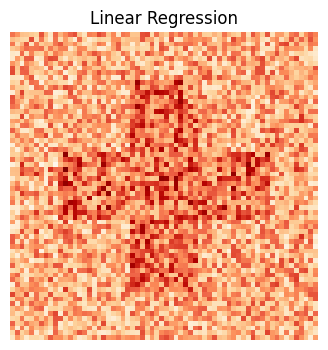

In [7]:
# Build model
linear_model = LinearRegressionModel() #  Linear Regression implemented above
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer_linear = torch.optim.SGD(linear_model.parameters(), lr=0.1)  # Stochastic Gradient Descent


# Train the model
epochs = 1

def reset_weights(m):
    '''
    Try resetting model weights to avoid weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Resetting {layer}')
            layer.reset_parameters()

# Apply the weight reset function
linear_model.apply(reset_weights)

for epoch in range(epochs):
    linear_model.train()
    running_loss = 0.0
    for data, labels in train_dataloader:
      optimizer_linear.zero_grad()  # Clear the gradients
      # Forward pass
      y_pred = linear_model(data)
      # Compute Loss
      loss = criterion(y_pred, labels)
      # Backward pass
      loss.backward()
      # Update weights
      optimizer_linear.step()
      running_loss += loss.item()*data.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')



linear_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Inference mode, gradients not needed
    for name, param in linear_model.named_parameters():
      if param.requires_grad and name == 'linear.weight':
        plt.figure(figsize=(4, 4))
        plt.imshow(tl.to_numpy(param), cmap=plt.cm.OrRd, interpolation='nearest')
        plt.axis('off')
        plt.title("Linear Regression")
        plt.show()


**Next I build the Tensor Regression model:**

In [8]:
# Like it is suggested in the paper in section 6.1,
# I've added batch normalization before and after the TCL/TRL
# to avoid vanishing or exploding gradients.


class TensorRegression(nn.Module):
    def __init__(self, input_dim, ranks, labels ,bias=False, efficient=False):
        super(TensorRegression, self).__init__()
        self.TRL = TRL(input_dim, ranks, labels, bias=bias, efficient=efficient)
        self.normalize_1 = torch.nn.BatchNorm1d(8)
        self.normalize_2 = torch.nn.BatchNorm1d(64)


    def forward(self, x):
      x = self.normalize_1(x)
      x = self.TRL(x)
      x = self.normalize_2(x)
      return x




**Now train the Tensor Resgression model and plot the weights tesnor folded into a matrix through the third mode $\mathcal{W}_{[2]}$:**

$$\space$$
NOTE: also here I reset the weights of the model between runs

/usr/local/lib/python3.10/dist-packages/tensorly/decomposition/_tucker.py:160: Warning: Given only one int for 'rank' instead of a list of 1 modes. Using this rank for all modes.
  warnings.warn(message, Warning)


Resetting BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resetting BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resetting BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resetting BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resetting BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Resetting BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Epoch [10/10], Loss: 27.5241


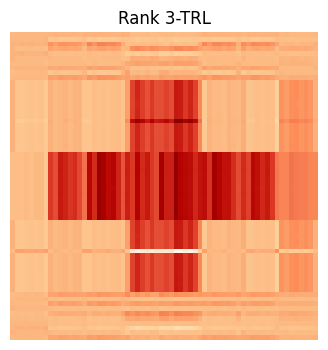

In [9]:
epochs = 10

input_dim = (8, 8)
ranks = (3, 3, 3)
label = 64
criterion_tensor = nn.MSELoss()  # Mean Squared Error Loss
tensor_regression_model = TensorRegression(input_dim, ranks, label, efficient=True)
optimizer_tensor = torch.optim.SGD(tensor_regression_model.parameters(), lr=0.7)

def reset_weights(m):
    '''
    Try resetting model weights to avoid weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Resetting {layer}')
            layer.reset_parameters()

# Apply the weight reset function
tensor_regression_model.apply(reset_weights)
tensor_regression_model.TRL.apply(reset_weights)
# tensor_regression_model.TRL.TCL.apply(reset_weights)

for epoch in range(epochs):
    tensor_regression_model.train()
    running_loss = 0.0
    for data, labels in train_dataloader:
      optimizer_tensor.zero_grad()  # Clear the gradients
      # Forward pass
      y_pred = tensor_regression_model(data)
      # Compute Loss
      loss = criterion_tensor(y_pred, labels)
      # Backward pass
      loss.backward()
      # Update weights
      optimizer_tensor.step()

      running_loss += loss.item()*data.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    if (epoch+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')


tensor_regression_model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Inference mode, gradients not needed
  if tensor_regression_model.TRL.efficient:
      g = tensor_regression_model.TRL.core_weights
      V_1 = tensor_regression_model.TRL.TCL.factor_0
      V_2 = tensor_regression_model.TRL.TCL.factor_1
      V_3 = tensor_regression_model.TRL.weights_factor
      W = tl.tenalg.multi_mode_dot(g, [V_1, V_2, V_3], modes=[0, 1, 2])
      if tensor_regression_model.TRL.bias:
        b = tensor_regression_model.TRL.weights_bias
        param = W + b
        param = tl.unfold(param, mode=2)
        plt.figure(figsize=(4, 4))
        plt.imshow(tl.to_numpy(param), cmap=plt.cm.OrRd, interpolation='nearest')
        plt.axis('off')
        plt.title(f'Rank {ranks[0]}-TRL')
        plt.show()

      else:
        param = W
        param = tl.unfold(W, mode=2)
        plt.figure(figsize=(4, 4))
        plt.imshow(tl.to_numpy(param), cmap=plt.cm.OrRd, interpolation='nearest')
        plt.axis('off')
        plt.title(f'Rank {ranks[0]}-TRL')
        plt.show()


  else:
    W = tensor_regression_model.TRL.weights
    if tensor_regression_model.TRL.bias:
        b = tensor_regression_model.TRL.weights_bias
        param = W + b
        param = tl.unfold(param, mode=2)
        plt.figure(figsize=(4, 4))
        plt.imshow(tl.to_numpy(param), cmap=plt.cm.OrRd, interpolation='nearest')
        plt.axis('off')
        plt.title(f'Rank {ranks[0]}-TRL')
        plt.show()
    else:
      param = W
      param = tl.unfold(W, mode=2)
      plt.figure(figsize=(4, 4))
      plt.imshow(tl.to_numpy(param), cmap=plt.cm.OrRd, interpolation='nearest')
      plt.axis('off')
      plt.title(f'Rank {ranks[0]}-TRL')
      plt.show()





# Moving next to the second part of the synthetic experiment:



**First implement the function that generates a dataset of desired size:**

In [10]:
def training_test_data(data_size):
  dataset = SyntheticDataset(data_size)

  # Now spliting the data set into train and test samples
  total_size = len(dataset)
  train_size = int(0.8 * total_size)
  test_size = total_size - train_size
  train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

  # Now create dataloader for train loops and test evaluation
  train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

  return train_dataloader, test_dataloader




Here I am trying to recreate the experiment that appears is the paper in figure 5. What is done here is training both models (Linear Regression and Tensor Regression) on bigger and bigger dataset and plot the resulting RMSE both on training data and test data. The plot that I've recieved is significantly different from what the authors published in the paper. I've tried to look for typos and errors on my end but didn't found any. I've tried also to give the models different number of epochs and learning rates but this didn't seem to help either.

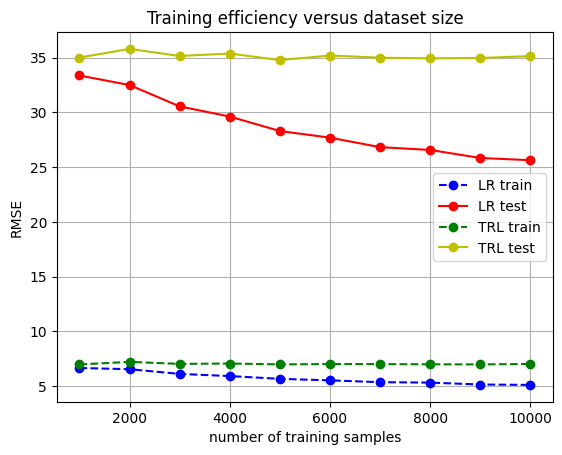

In [11]:
# Conducting the second part of the sythetic experiment of the paper
epochs = 10
num_data_samples = [(i+1)*1000 for i in range(10)]
criterion = nn.MSELoss()  # Mean Squared Error Loss


# The linear model:
linear_model = LinearRegressionModel()
optimizer_linear = torch.optim.SGD(linear_model.parameters(), lr=0.1)  # Stochastic Gradient Descent

# The TRL model:
input_dim_exp_2 =  (8, 8)
rank_exp_2 = (3, 3, 3)
label_exp_2 = 64
Tensor_model = TensorRegression(input_dim_exp_2, rank_exp_2, label_exp_2, efficient=True)
optimizer_tensor = torch.optim.SGD(tensor_regression_model.parameters(), lr=0.7)


models = [linear_model, Tensor_model]
optimizers = [optimizer_linear, optimizer_tensor]

linear_x_train = []
linear_y_train = []
linear_x_test = []
linear_y_test = []

tensor_x_train = []
tensor_y_train = []
tensor_x_test = []
tensor_y_test = []


def reset_weights(m):
  '''
  Try resetting model weights to avoid weight leakage.
  '''
  for layer in m.children():
      if hasattr(layer, 'reset_parameters'):
          # print(f'Resetting {layer}')
          layer.reset_parameters()

#  Apply the weight reset function
Tensor_model.apply(reset_weights)
Tensor_model.TRL.apply(reset_weights)
linear_model.apply(reset_weights)


for i in num_data_samples:
  for j in range(2):
      model = models[j]
      model.apply(reset_weights)
      training_data, test_data = training_test_data(i)
      if j == 1:
        model.TRL.apply(reset_weights)
      optimizer = optimizers[j]
      for epoch in range(epochs):
          model.train()
          running_loss = 0.0
          for data, labels in training_data:
            optimizer.zero_grad()  # Clear the gradients
            # Forward pass
            y_pred = model(data)
            # Compute Loss
            loss = torch.sqrt(criterion(y_pred, labels)) # Taking the RMSE loss
            # Backward pass
            loss.backward()
            # Update weights
            optimizer.step()


            running_loss += loss.item()*data.size(0)
      epoch_loss = running_loss / len(training_data.dataset)


      if j == 0:
        linear_x_train.append(i)
        linear_y_train.append(epoch_loss)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Inference mode, gradients not needed
          running_loss_test = 0.0
          for data, labels in test_data:
            y_pred = model(data)
            loss = torch.sqrt(criterion(y_pred, labels))
            running_loss += loss.item()*data.size(0)
          final_loss = running_loss / len(test_data.dataset)
          linear_x_test.append(i)
          linear_y_test.append(final_loss)

      if j ==1:
        tensor_x_train.append(i)
        tensor_y_train.append(epoch_loss)
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Inference mode, gradients not needed
          running_loss_test = 0.0
          for data, labels in test_data:
            y_pred = model(data)
            loss = torch.sqrt(criterion(y_pred, labels))
            running_loss += loss.item()*data.size(0)
          final_loss = running_loss / len(test_data.dataset)
          tensor_x_test.append(i)
          tensor_y_test.append(final_loss)


plt.plot(linear_x_train, linear_y_train, marker='o', linestyle='dashed', color='b', label="LR train")
plt.plot(linear_x_test, linear_y_test, marker='o', linestyle='-', color='r', label='LR test')
plt.plot(tensor_x_train, tensor_y_train, marker='o', linestyle='dashed', color='g', label='TRL train')
plt.plot(tensor_x_test, tensor_y_test, marker='o', linestyle='-', color='y', label='TRL test' )
plt.xlabel('number of training samples')
plt.ylabel('RMSE')
plt.title('Training efficiency versus dataset size')

plt.grid(True)  # Optional: add a grid for easier visualization
plt.legend()

plt.show()

#Second experiment with Fashion-MNIST instead of ImageNet

**First organize the MNIST dataset into train and test dataloaders and load the pretrained resnet50 model:**

In [15]:
from torchvision import datasets, transforms, models
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the dataset using mean and std deviation
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = models.resnet50(pretrained=True)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 41.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.24MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.74MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.86MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s] 


**Replace the first convolutional layer to match the MNIST dataset dimensions and change the last layer to match either new fully connected layer that will output 10 classes or with TRL with different low rank scenarios:**

In [16]:
# Using the identity layer in the following cell
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


def change_layers(model, i):
    if i ==0:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = nn.Linear(2048, 10, bias=True)
    elif i == 1:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.avgpool = TRL((2048, 1, 1), ranks=(8, 1, 1, 10), labels=10, efficient=True)
        model.fc = Identity()
    elif i == 2:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.avgpool = TRL((2048, 1, 1), ranks=(5, 1, 1, 10), labels=10, efficient=True)
        model.fc = Identity()
    elif i == 3:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.avgpool = TRL((2048, 1, 1), ranks=(2, 1, 1, 10), labels=10, efficient=True)
        model.fc = Identity()
    elif i == 4:
        model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.avgpool = TRL((2048, 1, 1), ranks=(1, 1, 1, 10), labels=10, efficient=True)
        model.fc = Identity()

    return model

change_layers(model, 0)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Next setting the loss function and the optimizer and training the model. After training switching to evaluation mode and measure the accuracy on the test set. $$\space$$

NOTE: The model's weights are saved after each epoch to the path that has to be specified in model_path.

In [13]:
if torch.cuda.is_available():
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [20]:
import time
model_path ='/content/model_path'
print('Training....')
total = 0
correct = 0
start = time.time()

for epoch in range(10):

   for i, data in enumerate(train_loader, 1):
      images, labels = data

      if(torch.cuda.is_available()):
          images = images.cuda()
          labels = labels.cuda()

      optimizer.zero_grad()
      outputs = model(images)

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      loss = criterion(outputs, labels)
      if(i%100 == 0):
          print('Epoch: {} Batch: {} loss: {}'.format(epoch, i, loss.item()))

      loss.backward()
      optimizer.step()
   torch.save(model.state_dict(), model_path)
   print(f'Saved PyTorch Model State to {model_path}')
print('Training Completed in: {} secs'.format(time.time()-start))
print('Training accuracy: {} %'.format((correct/total)*100))


Training....
Epoch: 0 Batch: 100 loss: 0.5670284628868103
Epoch: 0 Batch: 200 loss: 0.22535406053066254
Epoch: 0 Batch: 300 loss: 0.21363379061222076
Epoch: 0 Batch: 400 loss: 0.24496257305145264
Epoch: 0 Batch: 500 loss: 0.17116597294807434
Epoch: 0 Batch: 600 loss: 0.06590277701616287


KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to inference mode


def evaluate_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():  # No need to track gradients for validation data
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

accuracy = evaluate_accuracy(model, test_loader)
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')